# Convolutional Neural Networks
---

Nessa aula vamos treinar uma rede CNN para classificar imagens do dataset CIFAR-10 utilizando aumento de dados

O dataset é composto de imagens coloridas divididas em 10 classes, como mostrado no exemplo:

<img src='assets/cifar_data.png' width=70% height=70% />

### Testando na GPU [CUDA] (http://pytorch.org/docs/stable/cuda.html)

Como essas imagens são maiores (32x32x3) que o MNIST, pode ser muito útil acelerar o processo de treinamento usando processamento em placa de vídeo. CUDA é uma plataforma de computação paralela que utiliza tensores para computar informações na GPU.

In [1]:
import torch
import numpy as np

# testando se há gpu disponível
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA não está disponível. Treinamento na CPU ...')
else:
    print('CUDA está disponível! Treinamento na GPU ...')

CUDA está disponível! Treinamento na GPU ...


C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
## Carregando e aumentando os [dados] (https://pytorch.org/vision/stable/datasets.html)

Vamos carregar os dados de treinamento e teste, dividir o conjunto de treinamento em treinamento e validação, e criar os Dataloaders para cada um desses conjuntos.


#### Aumento de dados

Vamos também executar uma forma simples de aumento de dados que inverte e rotaciona as imagens de forma aleatoria. Isso é feito definindo uma transformação do `torchvision`. Você pode procurar mais tipos de transformações para pre-processamento e aumento de dados [aqui](https://pytorch.org/vision/stable/transforms.html).


Este tipo de aumento de dados deve adicionar alguma variedade em relação à posição das imagens, para que quando treinarmos o modelo ele seja robusto em relação a mudancas geométricas (exemplo: reconhecer um navio, independente da direção em que ele esteja apontando). É recomendavel sempre escolher uma ou duas transformações.

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
#from torchvision import datasets
#import torchvision.transforms as transforms
#from torch.utils.data.sampler import SubsetRandomSampler

# numero de subprocessos usados para carregar os dados
num_workers = 0
# quantas amostras serao carregadas para cada batch
batch_size = 100
# porcentagem dos conjuntos de treinamento e validacao
valid_size = 0.2

# converte os dados para um torch.FloatTensor normalizado
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # inverte e rotaciona aleatoriamente
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# escolhe os dados de treino e teste
train_data = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', train=False,
                             download=True, transform=transform)

# obtem os indices de treino que serao usados para validacao
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define os samplers para extrair os batches de treinamento e validacao
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepara os data loaders (combina o dataset e o sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# especifica a classe das imagens
classes = ['aviao', 'automovel', 'passaro', 'gato', 'veado',
           'cachorro', 'sapo', 'cavalo', 'navio', 'caminhao']

Files already downloaded and verified
Files already downloaded and verified


### Visualizando o batch de treinamento

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# funcao auxiliar para "desnormalizar" e mostrar a imagem
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))  # converte o tensor para imagem

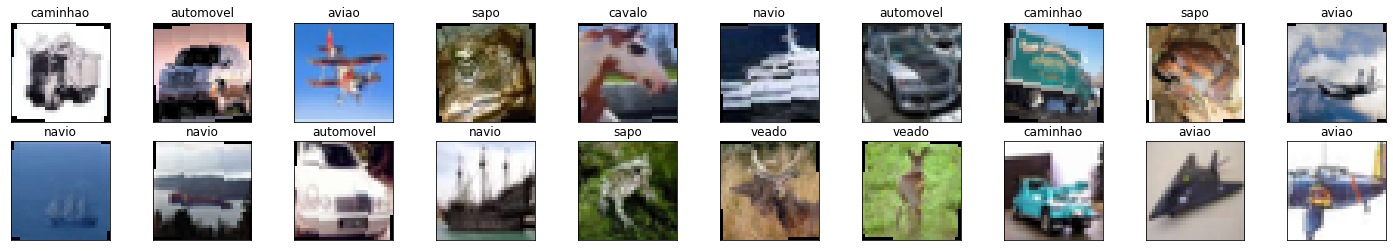

In [5]:
# obtem um batch de amostras de treinamento
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # converte as imagens para formato numpy para apresentar

# plota as imagens no batch, junto dos respectivos rotulos
fig = plt.figure(figsize=(25, 4))

# mostra 20 imagens
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### Visualizando as imagens com maiores detalhes

Aqui nós olhamos para os canais vermelho, verde e azul (RGB) normalizados como três canais separados de intensidade em tons de cinza.

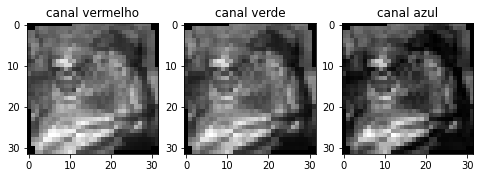

In [6]:
rgb_img = np.squeeze(images[3])
channels = ['canal vermelho', 'canal verde', 'canal azul']
color = ['Reds', 'Greens', 'Blues']
fig = plt.figure(figsize = (8, 8)) 

for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])

In [7]:
rgb_img = np.squeeze(images[3])
channels = ['canal vermelho', 'canal verde', 'canal azul']

fig = plt.figure(figsize = (36, 36)) 

"""for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')
"""

"for idx in np.arange(rgb_img.shape[0]):\n    ax = fig.add_subplot(1, 3, idx + 1)\n    img = rgb_img[idx]\n    ax.imshow(img, cmap='gray')\n    ax.set_title(channels[idx])\n    width, height = img.shape\n    thresh = img.max()/2.5\n    for x in range(width):\n        for y in range(height):\n            val = round(img[x][y],2) if img[x][y] !=0 else 0\n            ax.annotate(str(val), xy=(y,x),\n                    horizontalalignment='center',\n                    verticalalignment='center', size=8,\n                    color='white' if img[x][y]<thresh else 'black')\n"

<Figure size 2592x2592 with 0 Axes>

---
## Definindo a  [arquitetura](http://pytorch.org/docs/stable/nn.html) da rede

Agora vamos definir a arquitetura da CNN. Em vez de camadas lineares, como nas redes MLP, vamos usar as seguintes camadas:
* [Camadas convolucionais](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d), as quais podem ser consideradas um "empilhamento de imagens filtradas".
* [Camadas Maxpooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d), as quais reduzem as dimensões de uma entrada, mantendo apenas os pixels mais ativos da camada anterior.
* As já conhecidas camadas lineares e Dropout para evitar _overfitting_ e produzir uma saída de dimensionalidade igual a 10 (número de classes).

A imagem abaixo apresenta 2 camadas convolucionais.

<img src='assets/2_layer_conv.png' height=50% width=50% />

#### Definindo um modelo com multiplas camadas convolucionais e definindo o comportamento do modelo durante a passagem feedforward.

Note que quanto mais camadas convolucionais forem incluídas, mais complexos são os padrões de cor e forma que o modelo é capaz de detectar. Para essa tarefa, é sugerido um modelo com 2 ou 3 camadas convolucionais, com camadas lineares e Dropout para evitar _overfitting_. Para termos uma ideia de como escolher esses valores, um bom ponto de partida seria procurar trabalhos já publicados. 


In [8]:
import torch.nn as nn
import torch.nn.functional as F

# Definindo nossa arquitetura
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Camada convolucional (enxerga um tensor representando uma imagem de dimensao 32x32x3)
        # primeiro parametro é o numero de canais de entrada, segundo é o numero de canais de saida (16 filtros)
        # terceiro e o tamanho do kernel (filtro de 3x3) e o padding=1 evita que a imagem seja redimensionada.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # camada max pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # camada linear (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500) # linear = W'X + b
        
        # camada linear (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        
        # camada dropout (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # adiciona uma sequencia de convolucoes e maxpooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # achata x, transformando em um vetor
        x = x.view(-1, 64 * 4 * 4)
        # adiciona a camada dropout
        x = self.dropout(x)
        # adiciona a primeira camada escondida, com ativacao relu
        x = F.relu(self.fc1(x))
        # adiciona uma camada dropout
        x = self.dropout(x)
        # adiciona segunda camada escondida, com ativacao relu
        x = self.fc2(x)
        return x

# cria a CNN completa
model = Net()
print(model)

# move os tensores pra GPU, se o CUDA estiver disponivel
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Definindo a  [função de custo](https://pytorch.org/docs/stable/nn.html#loss-functions)

Precisamos decidir qual a melhor função de custo e otimização para a tarefa de classificação.
Precisamos também prestar atenção ao valor da **taxa de aprendizado**, uma vez que ela determina como o modelo vai convergir para um erro menor.

In [9]:
import torch.optim as optim

# especificamos como funcao de custo a funncao categorical cross-entropy
criterion = nn.CrossEntropyLoss()

# e o otimizador Adam 
optimizer = optim.Adam(model.parameters(), lr=0.001)

---
## Treinando a rede

Lembrem que precisamos verificar como o custo de treinamento e validação diminuem conforme o tempo. Se o custo de validação aumenta, pode indicar _overfitting_.

In [10]:
# numero de epocas de treinamento
n_epochs = 20

valid_loss_min = np.Inf # mantem registro do custo minimo de validacao

for epoch in range(1, n_epochs+1):

    # mantem registro dos custos de treinamento e validacao
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # treina o modelo #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move os tensores pra GPU se o CUDA estiver disponivel
        if train_on_gpu:
            data, target = data.cuda(), target.cuda() 
        # limpa os gradientes de todas as variaveis otimizadas
        optimizer.zero_grad()
        # passo forward: computa as saidas do modelo
        output = model(data)
        # calcula o custo por batch
        loss = criterion(output, target)
        # passo backward: computa o gradiente do custo em respeito aos parametros do modelo
        loss.backward()
        # executa um unico passo de otimizacao (atualizacao dos parametros)
        optimizer.step()
        # atualiza o custo de trein
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # valida o modelo #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move os tensores para a GPU se o CUDA estiver disponivel
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # passo forward: computa as saidas do modelo
        output = model(data)
        # calcula o custo por batch
        loss = criterion(output, target)
        # atualiza o custo de validacao
        valid_loss += loss.item()*data.size(0)
    
    # calcula a media dos custos
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # imprime  as estatisticas de treino e validacao 
    print('Época: {} \tCusto de treinamento: {:.3f} \tCusto de validação: {:.3f}'.format(
        epoch, train_loss, valid_loss))
    
    # salva o modelo se o custo de validacao diminuir
    if valid_loss <= valid_loss_min:
        print('Redução do custo de validação ({:.3f} --> {:.3f}).  Salvando o modelo ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Época: 1 	Custo de treinamento: 1.615 	Custo de validação: 1.358
Redução do custo de validação (inf --> 1.358).  Salvando o modelo ...
Época: 2 	Custo de treinamento: 1.305 	Custo de validação: 1.202
Redução do custo de validação (1.358 --> 1.202).  Salvando o modelo ...
Época: 3 	Custo de treinamento: 1.172 	Custo de validação: 1.058
Redução do custo de validação (1.202 --> 1.058).  Salvando o modelo ...
Época: 4 	Custo de treinamento: 1.089 	Custo de validação: 0.996
Redução do custo de validação (1.058 --> 0.996).  Salvando o modelo ...
Época: 5 	Custo de treinamento: 1.022 	Custo de validação: 0.951
Redução do custo de validação (0.996 --> 0.951).  Salvando o modelo ...
Época: 6 	Custo de treinamento: 0.966 	Custo de validação: 0.918
Redução do custo de validação (0.951 --> 0.918).  Salvando o modelo ...
Época: 7 	Custo de treinamento: 0.927 	Custo de validação: 0.883
Redução do custo de validação (0.918 --> 0.883).  Salvando o modelo ...
Época: 8 	Custo de treinamento: 0.887 	Cust

### Carregando o modelo com menor custo de validação

In [11]:
model.load_state_dict(torch.load('model_augmented.pt'))

<All keys matched successfully>

---
## Testando a rede treinada

Como o modelo se sai em dados novos?

Um "bom" resultado para esse banco seria uma CNN com acurácia por volta de 90% (ou mais, tente melhorar) sobre as imagens de teste.

In [12]:
# registra o custo de teste
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
soft = nn.Softmax(dim=1)
model.eval()
# itera sobre os dados de teste
for batch_idx, (data, target) in enumerate(test_loader):
    # move os tensores pra GPU, se disponivel
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # passo forward: computa as saidas do modelo
    output = model(data)
    # computa o custo do batch
    loss = criterion(output, target)
    # atualiza o custo de teste
    test_loss += loss.item()*data.size(0)
    # converte as probabilidades para a classe predita
    _, pred = torch.max(soft(output), 1)
    # compara as predicoes com os rotulos reais
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # computa a acuracia para cada classe
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# media de custo de teste
test_loss = test_loss/len(test_loader.dataset)
print('Custo de teste: {:.3f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Acurácia de teste de %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Acurácia de teste de %5s: N/A (nenhuma amostra vista no treinamento)' % (classes[i]))

print('\nAcurácia de teste (Geral): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Custo de teste: 0.701

Acurácia de teste de aviao: 78% (787/1000)
Acurácia de teste de automovel: 92% (920/1000)
Acurácia de teste de passaro: 64% (643/1000)
Acurácia de teste de  gato: 55% (552/1000)
Acurácia de teste de veado: 68% (689/1000)
Acurácia de teste de cachorro: 67% (671/1000)
Acurácia de teste de  sapo: 82% (825/1000)
Acurácia de teste de cavalo: 80% (804/1000)
Acurácia de teste de navio: 87% (879/1000)
Acurácia de teste de caminhao: 78% (784/1000)

Acurácia de teste (Geral): 75% (7554/10000)


### Visualizando os resultados de teste

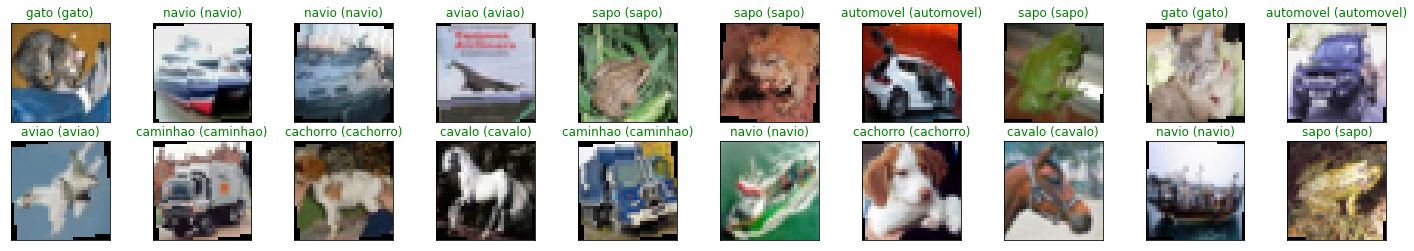

In [18]:
# obtendo um batch de amostras de teste
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# movendo as entradas para GPU
if train_on_gpu:
    images = images.cuda()

# obtendo as saidas
output = model(images)
# convertendo as probabilidades em classes
_, preds_tensor = torch.max(soft(output), 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plotando as imagens do batch junto com a classe predita e real
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx].to('cpu'))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

### Podemos visualizar os pesos aprendidos nas camadas convolucionais...

Shape torch.Size([16, 3, 3, 3])


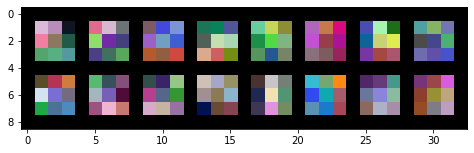

In [20]:
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape
    print("Shape", tensor.shape)

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding).permute((1,2,0))
    plt.figure( figsize=(nrow,rows) )
    #plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.imshow(grid.numpy())



k_filter = model.conv1.weight.detach().cpu().data.clone()
visTensor(k_filter, ch=0, allkernels=False)

# Exercicios

1. Pesquise a [documentacao sobre transformações](https://pytorch.org/vision/stable/transforms.html) e adicione outros tipos de transformação para aumento de dados e veja como o modelo vai se comportar.

2. Tentar modificar o modelo para conseguir uma acurácia maior sobre o conjunto de teste.